# 7장 다중 분류

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache direc

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [ ]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

## 7.8 데이터 준비

### 데이터 불러오기

In [ ]:
# 학습용 데이터 준비

# 라이브러리 임포트
from sklearn.datasets import load_iris

# 데이터 불러오기
iris = load_iris()

# 입력 데이터와 정답 데이터
x_org, y_org = iris.data, iris.target

# 결과 확인
print('원본 데이터', x_org.shape, y_org.shape)

원본 데이터 (150, 4) (150,)


### 데이터 추출

In [ ]:
# 데이터 추출

# 입력 데이터로 sepal(꽃받침) length(0)와 petal(꽃잎) length(2)를 추출
x_select = x_org[:,[0,2]]

# 결과 확인
print('원본 데이터', x_select.shape, y_org.shape)

원본 데이터 (150, 2) (150,)


### 훈련 데이터와 검증 데이터 분할

In [ ]:
# 훈련 데이터와 검증 데이터로 분할(셔플도 동시에 실시함)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75,
    random_state=123)
print('--- 데이터 분할 확인 ---')
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

--- 데이터 분할 확인 ---
(75, 2) (75, 2) (75,) (75,)


### 훈련 데이터의 산포도 출력

In [ ]:
# 데이터를 정답별로 분할

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

In [ ]:
print(x_t0[:5])
print(x_t1[:5])
print(x_t2[:5])

[[5.  1.6]
 [5.  1.6]
 [4.9 1.4]
 [5.8 1.2]
 [4.6 1.4]]
[[6.3 4.7]
 [7.  4.7]
 [6.1 4. ]
 [6.5 4.6]
 [5.5 3.8]]
[[6.4 5.6]
 [6.3 5. ]
 [6.3 6. ]
 [6.9 5.4]
 [6.7 5.8]]


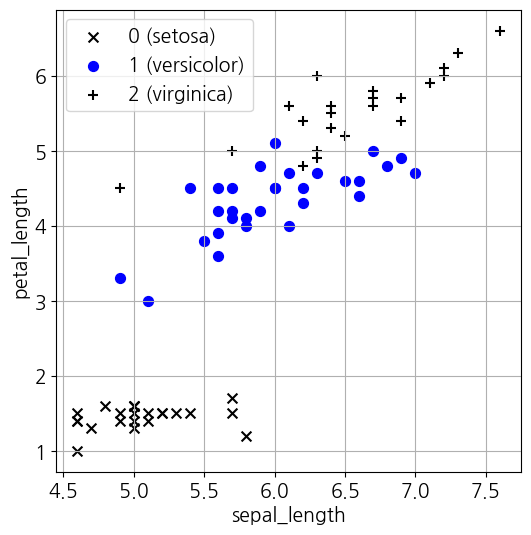

In [ ]:
# 산포도 출력: 실데이터 분포확인 >> 변수간 상관관계 확인. 누가봐도 신뢰할 수 있게 한다.

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolor)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

## 7.9 모델 정의

In [ ]:
print(x_train[:5])
print(x_train[:5].shape)

[[6.3 4.7]
 [7.  4.7]
 [5.  1.6]
 [6.4 5.6]
 [6.3 5. ]]
(5, 2)


In [ ]:
print(y_train[:5])
print(list(set(y_train[:5])))

[1 1 0 2 2]
[np.int64(0), np.int64(1), np.int64(2)]


In [ ]:
# 학습용 파라미터 설정

# 입력 차원수
n_input = x_train.shape[1] # 입력 변수의 열

# 출력 차원수
# 분류 클래스 수, 여기서는 3
n_output = len(list(set(y_train)))

# 결과 확인
print('--- 입출력 차원 확인 ---')
print(f'n_input: {n_input}  n_output: {n_output}')

--- 입출력 차원 확인 ---
n_input: 2  n_output: 3


In [ ]:
# 모델 정의
# 2입력 3출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)

        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1

# 인스턴스 생성
net = Net(n_input, n_output)

### 모델 확인

In [ ]:
# 모델 내부 파라미터 확인
# l1.weight는 행렬, l1.bias는 벡터

print('--- 모델 파라미터 확인 ---')
for parameter in net.named_parameters():
    print(parameter)

--- 모델 파라미터 확인 ---
('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [ ]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


In [ ]:
# 모델 개요 표시 2
# params는 w와 b

summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [3]                       --
├─Linear: 1-1                            [3]                       9
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 최적화 알고리즘과 손실 함수의 정의

In [ ]:
# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

## 7.10 경사 하강법

### 데이터의 텐서 변수화

In [ ]:
# 입력 데이터 x_train과 정답 데이터 y_train의 텐서 변수화

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long() # 반드시 정수설정(**)

# 검증 데이터의 텐서 변수화

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

### 손실의 계산 그래프 시각화

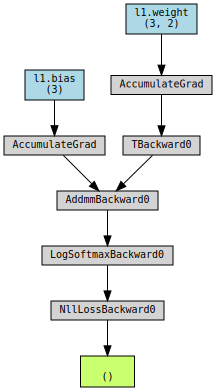

In [ ]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실의 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 예측 라벨을 얻는 방법

In [ ]:
# torch.max 함수 호출
# 2번째 인수는 축을 의미함. 1이면 행별로 집계
print(torch.max(outputs, 1))

torch.return_types.max(
values=tensor([12.0000, 12.7000,  7.6000, 13.0000, 12.3000,  7.6000,  7.3000, 11.1000,
        12.1000, 13.3000,  8.0000,  7.0000, 10.3000,  7.6000, 11.7000, 13.3000,
         7.4000, 13.5000,  8.2000,  8.4000, 12.7000,  6.6000,  7.9000, 12.2000,
        14.6000, 12.0000, 10.2000, 10.5000,  7.1000,  7.3000, 12.6000, 12.7000,
         7.4000,  7.7000, 10.8000, 11.5000, 11.5000, 14.0000, 12.8000, 10.8000,
        10.8000, 15.2000,  7.5000,  7.8000, 11.1000, 13.6000, 12.9000, 14.2000,
        12.7000,  7.6000, 10.9000,  7.0000, 10.9000, 11.2000,  7.4000, 11.7000,
        13.3000, 11.5000, 13.4000, 12.7000,  7.7000, 11.8000,  7.0000, 12.6000,
        11.7000, 10.9000,  9.2000, 12.2000, 10.4000, 12.1000,  7.5000,  9.1000,
        11.1000, 12.0000, 14.3000], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [ ]:
# 예측 라벨 리스트를 취득
print(torch.max(outputs, 1)[0])
print(torch.max(outputs, 1)[1])

tensor([0.9056, 0.9792, 0.9452, 0.9596, 0.8256, 0.9768, 0.9668, 0.9644, 0.8989,
        0.9922, 0.9979, 0.9826, 0.9449, 0.9731, 0.5591, 0.6956, 0.9517, 0.9415,
        0.9976, 0.9871, 0.7629, 0.9961, 0.9903, 0.9628, 0.8912, 0.9702, 0.9374,
        0.9509, 0.9606, 0.9904, 0.9285, 0.8494, 0.9640, 0.9847, 0.8810, 0.9167,
        0.9609, 0.8964, 0.9424, 0.9508, 0.9325, 0.9622, 0.9803, 0.9899, 0.9233,
        0.9017, 0.7451, 0.6671, 0.7156, 0.9809, 0.6719, 0.9816, 0.9694, 0.8285,
        0.9818, 0.6172, 0.9491, 0.8453, 0.9575, 0.8556, 0.9953, 0.8961, 0.9750,
        0.9072, 0.9590, 0.9298, 0.9396, 0.6031, 0.9009, 0.7142, 0.9878, 0.8908,
        0.7544, 0.5214, 0.9295], grad_fn=<MaxBackward0>)
tensor([1, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1,
        2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2,
        2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2, 0, 1, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1,
        1, 2, 2])


### 반복 계산

In [ ]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [ ]:
# 반복 계산 메인 루프

for epoch in range(num_epochs):

    # 훈련 페이즈

    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()

    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum() / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ((epoch) % 1000 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

      # 해석
      # 과소적합 의심. 샘플이 너무 적은 상태. 훈련 acc에 90% 인데, 실제 검증데이터 val_acc에서 96% 출력
      # 과적합 의심. acc가 0.99인데, 실 데이터에서 0.86. 일반화가 안 되었다고 해석

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [1000/10000], loss: 0.45458 acc: 0.89333 val_loss: 0.44133, val_acc: 0.92000
Epoch [2000/10000], loss: 0.36869 acc: 0.90667 val_loss: 0.35477, val_acc: 0.94667
Epoch [3000/10000], loss: 0.32137 acc: 0.90667 val_loss: 0.30714, val_acc: 0.94667
Epoch [4000/10000], loss: 0.29052 acc: 0.90667 val_loss: 0.27581, val_acc: 0.96000
Epoch [5000/10000], loss: 0.26879 acc: 0.90667 val_loss: 0.25354, val_acc: 0.96000
Epoch [6000/10000], loss: 0.25269 acc: 0.90667 val_loss: 0.23687, val_acc: 0.96000
Epoch [7000/10000], loss: 0.24030 acc: 0.90667 val_loss: 0.22391, val_acc: 0.96000
Epoch [8000/10000], loss: 0.23046 acc: 0.90667 val_loss: 0.21353, val_acc: 0.96000
Epoch [9000/10000], loss: 0.22247 acc: 0.90667 val_loss: 0.20501, val_acc: 0.96000


## 7.11 결과 확인

In [ ]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09263  정확도 : 0.26667
최종상태 : 손실 : 0.20501  정확도 : 0.96000


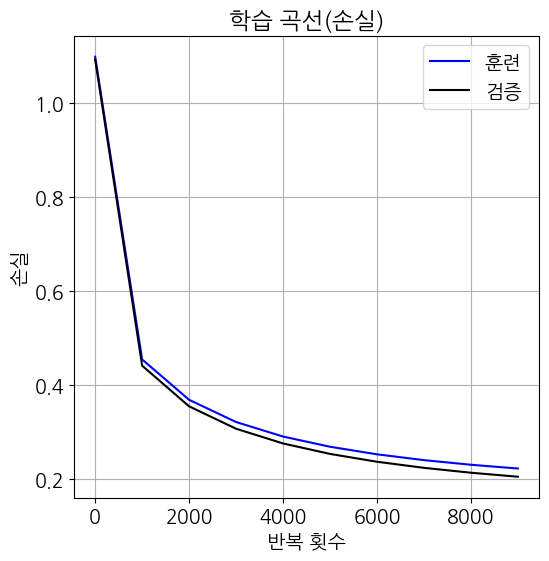

In [ ]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

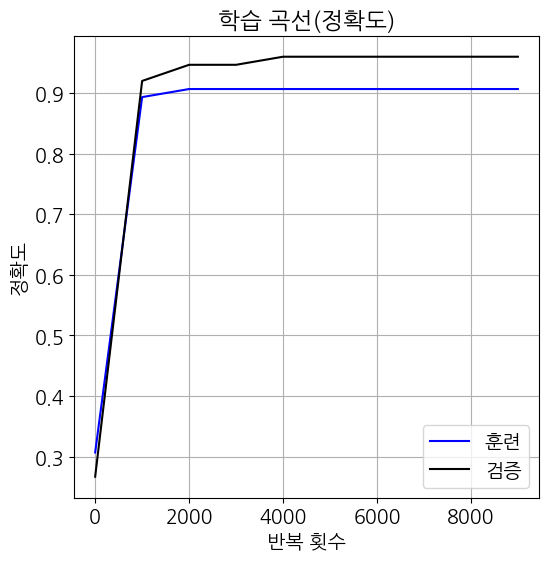

In [ ]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

### 모델 출력 확인

In [ ]:
# 정답 데이터 0, 1, 2에 해당하는 샘플 각각 추출
print('--- 모델 출력값 확인 ---')
indices_to_check = [0, 2, 3]
print(f'확인할 샘플의 정답 레이블: {labels[indices_to_check].numpy()}')

--- 모델 출력값 확인 ---
확인할 샘플의 정답 레이블: [1 0 2]


In [ ]:
# 해당 입력값 추출
i3 = inputs[indices_to_check, :]
print(f'해당 입력값:\n{i3.data.numpy()}')

해당 입력값:
[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [ ]:
# 소프트맥스 함수 정의 및 적용
softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)

print(f'\n모델의 원시 출력 (logits):\n{o3.data.numpy()}')
print(f'소프트맥스 적용 후 확률:\n{k3.data.numpy()}')


모델의 원시 출력 (logits):
[[ 8.8071 14.1937 12.9986]
 [12.8262  9.8     0.1734]
 [ 6.7954 15.0928 17.1111]]
소프트맥스 적용 후 확률:
[[0.0035 0.765  0.2315]
 [0.9537 0.0463 0.    ]
 [0.     0.1173 0.8827]]


### 가중치 행렬과 바이어스 값

In [ ]:
# 가중치 행렬
print(f'가중치 행렬:\n{net.l1.weight.data}')
# 편향
print(f'편향:\n{net.l1.bias.data}')

가중치 행렬:
tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
편향:
tensor([ 1.7178,  1.6563, -0.3741])


## 7.12 입력 변수의 4차원화

In [ ]:
# 훈련 데이터와 검증 데이터로 분할(셔플도 동시에 실시함)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 입력 차원수
n_input = x_train.shape[1]

(75, 4) (75, 4) (75,) (75,)


In [ ]:
print('입력 데이터(x)')
print(x_train[:5,:])
print(f'입력 차원수: {n_input}')

입력 데이터(x)
[[6.3 3.3 4.7 1.6]
 [7.  3.2 4.7 1.4]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]
 [6.3 2.5 5.  1.9]]
입력 차원수: 4


In [ ]:
# 입력 데이터 x_train과 정답 데이터 y_train의 텐서 변수화
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 검증용 데이터의 텐서 변수화
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [ ]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()s

# 최적화 알고리즘: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [ ]:
for epoch in range(num_epochs):

    # 훈련 페이즈

    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()

    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]
    # 행별로 계산한 차원, 열별로 출력

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ( epoch % 1000 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [1000/10000], loss: 0.37106 acc: 0.97333 val_loss: 0.36017, val_acc: 0.96000
Epoch [2000/10000], loss: 0.27799 acc: 0.97333 val_loss: 0.27252, val_acc: 0.96000
Epoch [3000/10000], loss: 0.22870 acc: 0.98667 val_loss: 0.22713, val_acc: 0.96000
Epoch [4000/10000], loss: 0.19802 acc: 0.98667 val_loss: 0.19931, val_acc: 0.96000
Epoch [5000/10000], loss: 0.17703 acc: 0.98667 val_loss: 0.18053, val_acc: 0.96000
Epoch [6000/10000], loss: 0.16172 acc: 0.98667 val_loss: 0.16700, val_acc: 0.96000
Epoch [7000/10000], loss: 0.15003 acc: 0.98667 val_loss: 0.15680, val_acc: 0.96000
Epoch [8000/10000], loss: 0.14078 acc: 0.98667 val_loss: 0.14883, val_acc: 0.96000
Epoch [9000/10000], loss: 0.13327 acc: 0.98667 val_loss: 0.14243, val_acc: 0.96000


In [ ]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09158  정확도 : 0.26667
최종상태 : 손실 : 0.14243  정확도 : 0.96000


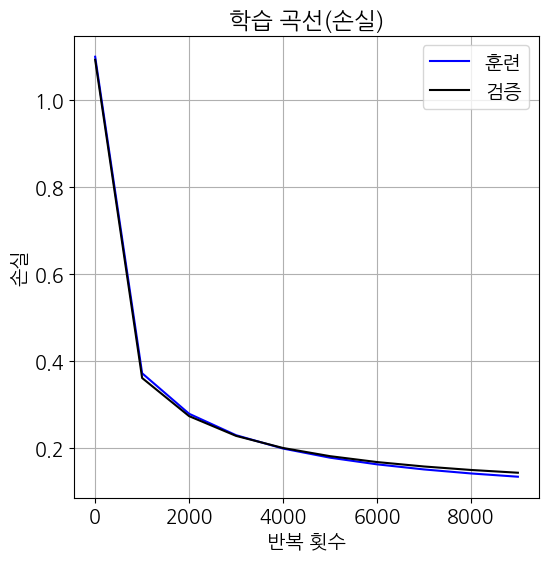

In [ ]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

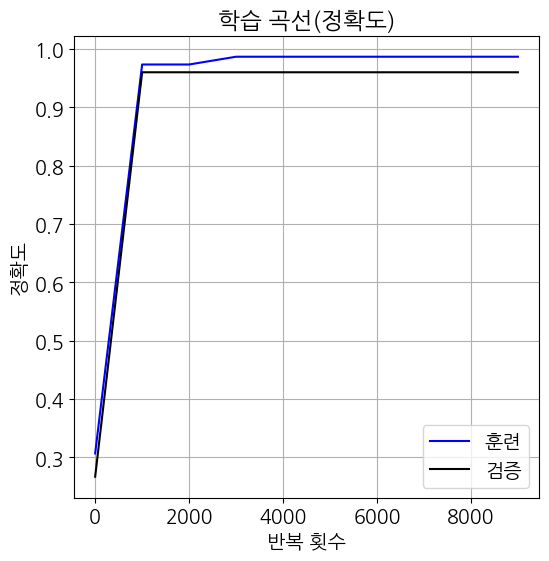

In [ ]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

## 칼럼 NLLLoss 함수의 거동

NLLLoss 함수가 뭐예요
- Negative Log Likelihood 음의 로그 가능도
- 다중분류에서 모델이 낸 각 클래스의 확률 중 정답클래싀 확률이 얼마나 높나/낮나를 저점수로 메기는 손실함수
- 정답일 가능도(likelihood)가 높으면 >> 손실이 낮다
- likelihood가 낮으면 >> 손실이 높다
- NLLLoss = -log(P(True))

In [ ]:
# 가상의 모델 출력 (로그 확률이라고 가정)
outputs_np = np.array(range(1, 13)).reshape((4, 3))
# 가상의 정답 레이블
labels_np = np.array([0, 1, 2, 0])

# 텐서로 변환
outputs_dummy = torch.tensor(outputs_np).float()
labels_dummy = torch.tensor(labels_np).long()

print("--- 입력 데이터 ---")
print("Outputs (가정: 로그 확률):")
print(outputs_dummy.data)
print("\nLabels (인덱스):")
print(labels_dummy.data)

--- 입력 데이터 ---
Outputs (가정: 로그 확률):
tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])

Labels (인덱스):
tensor([0, 1, 2, 0])


In [ ]:
# NLLLoss 함수 호출

nllloss = nn.NLLLoss()
loss = nllloss(outputs_dummy, labels_dummy)
print(loss.item())

-6.25


In [ ]:
print("--- NLLLoss 계산 결과 ---")
print(loss.item())
print("\n--- 손실 계산 과정 ---")
# labels_dummy를 인덱스로 사용하여 각 행에서 값 추출
selected_values = [outputs_dummy[i, labels_dummy[i]].item() for i in range(len(labels_dummy))]
print(f"추출된 값들: {selected_values}")
# 평균을 내고 음수(-) 붙이기
manual_loss = -np.mean(selected_values)
print(f"손실 계산 결과: {manual_loss}")

--- NLLLoss 계산 결과 ---
-6.25

--- 손 계산 과정 ---
추출된 값들: [1.0, 5.0, 9.0, 10.0]
손 계산 결과: -6.25


## 칼럼 다중 분류 모델의 또 다른 구현 패턴

### 패턴2 모델 클래스측에 LogSoftmax 함수를 포함

In [ ]:
# 모델 정의
# 2입력 3출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # logsoftmax 함수 정의
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.logsoftmax(x1)
        return x2

In [ ]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： NLLLoss 함수
criterion = nn.NLLLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

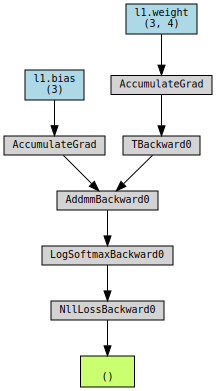

In [ ]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실의 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [ ]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： NLLLoss 함수
criterion = nn.NLLLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [ ]:
for epoch in range(num_epochs):

    # 훈련 페이즈

    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()

    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ( epoch % 1000 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [1000/10000], loss: 0.37106 acc: 0.97333 val_loss: 0.36017, val_acc: 0.96000
Epoch [2000/10000], loss: 0.27799 acc: 0.97333 val_loss: 0.27252, val_acc: 0.96000
Epoch [3000/10000], loss: 0.22870 acc: 0.98667 val_loss: 0.22713, val_acc: 0.96000
Epoch [4000/10000], loss: 0.19802 acc: 0.98667 val_loss: 0.19931, val_acc: 0.96000
Epoch [5000/10000], loss: 0.17703 acc: 0.98667 val_loss: 0.18053, val_acc: 0.96000
Epoch [6000/10000], loss: 0.16172 acc: 0.98667 val_loss: 0.16700, val_acc: 0.96000
Epoch [7000/10000], loss: 0.15003 acc: 0.98667 val_loss: 0.15680, val_acc: 0.96000
Epoch [8000/10000], loss: 0.14078 acc: 0.98667 val_loss: 0.14883, val_acc: 0.96000
Epoch [9000/10000], loss: 0.13327 acc: 0.98667 val_loss: 0.14243, val_acc: 0.96000


In [ ]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09158  정확도 : 0.26667
최종상태 : 손실 : 0.14243  정확도 : 0.96000


In [ ]:
# 패턴 2 모델의 출력 결과
w = outputs[:5,:].data
print(w.numpy())

# 확률값을 얻고 싶은 경우
print(torch.exp(w).numpy())

[[ -5.1283  -0.0992  -2.4251]
 [ -4.9799  -0.021   -4.274 ]
 [ -0.0563  -2.9047 -16.2378]
 [-11.7813  -3.2099  -0.0412]
 [ -9.2329  -1.747   -0.1916]]
[[0.0059 0.9056 0.0885]
 [0.0069 0.9792 0.0139]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]
 [0.0001 0.1743 0.8256]]


### 패턴 3 모델 클래스측에 본연의 소프트맥스 함수를 포함

In [ ]:
# 모델 정의
# 2입력 3출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # 소프트맥스 함수 정의
        self.softmax = nn.Softmax(dim=1)

        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.softmax(x1)
        return x2

In [ ]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： NLLLoss 함수
criterion = nn.NLLLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [ ]:
for epoch in range(num_epochs):

    # 훈련 페이즈

    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 여기서 로그 함수를 적용함
    outputs2 = torch.log(outputs)

    # 손실 계산
    loss = criterion(outputs2, labels)

    # 경사 계산
    loss.backward()

    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 여기서 로그 함수를 적용함
    outputs2_test = torch.log(outputs_test)

    # 손실 계산
    loss_test = criterion(outputs2_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ( epoch % 1000 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [1000/10000], loss: 0.37106 acc: 0.97333 val_loss: 0.36017, val_acc: 0.96000
Epoch [2000/10000], loss: 0.27799 acc: 0.97333 val_loss: 0.27252, val_acc: 0.96000
Epoch [3000/10000], loss: 0.22870 acc: 0.98667 val_loss: 0.22713, val_acc: 0.96000
Epoch [4000/10000], loss: 0.19802 acc: 0.98667 val_loss: 0.19931, val_acc: 0.96000
Epoch [5000/10000], loss: 0.17703 acc: 0.98667 val_loss: 0.18053, val_acc: 0.96000
Epoch [6000/10000], loss: 0.16172 acc: 0.98667 val_loss: 0.16700, val_acc: 0.96000
Epoch [7000/10000], loss: 0.15003 acc: 0.98667 val_loss: 0.15680, val_acc: 0.96000
Epoch [8000/10000], loss: 0.14078 acc: 0.98667 val_loss: 0.14883, val_acc: 0.96000
Epoch [9000/10000], loss: 0.13327 acc: 0.98667 val_loss: 0.14243, val_acc: 0.96000


In [ ]:
# 손실과 정확도 확인
print("수동 log 적용 후 손실 계산 가능:" , loss_test.item())
print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

수동 log 적용 후 손실 계산 가능: 0.13719221949577332
초기상태 : 손실 : 1.09158  정확도 : 0.26667
최종상태 : 손실 : 0.14243  정확도 : 0.96000


In [ ]:
# 패턴 3 모델의 출력값
w = outputs[:5,:].data.numpy()
print(w)

[[0.0059 0.9056 0.0885]
 [0.0069 0.9792 0.0139]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]
 [0.0001 0.1743 0.8256]]


In [ ]:
# eos